In [1]:
import torch
import torchvision
from matplotlib import pyplot
from keras.datasets import cifar10
import numpy as np
import librosa
from librosa import display
from PIL import Image
from matplotlib import pyplot
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import cmath
import seaborn as sns
import scipy
import IPython.display as ipd
import math
from numpy.linalg import inv
import torch 
import torchvision
from torchvision import datasets
import numpy as np
import time
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda") 

## Uploading Training and Test Data Set

In [2]:
# load dataset
device = torch.device("cuda") 
(trainX, trainy), (testX, testy) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


## Function for Standardizing the Variables

In [3]:
### Standardized Image for the baseline model
def function_std(input):
  new_input= (input-0.5)/0.5
  
  return new_input

## Function for the changing the data into Channels X Length X Width

In [4]:
def change_into_channels(input):
  num1=[]
  for k in range(len(input)):
    num2=[]
    for j in range(3):
      num2.append(input[k][:,:,j])
    num1.append(num2)
  return num1

## Function for Data Manipulation for performing the data manipulation

The below function return the baseline dataset of 45000 images if baseline argument is kept true else return the augmented dataset with 180000 images

In [5]:

def data_manipulation(train_X,train_y,baseline):
  ### validation_set
  valid_norm= np.array(train_X[45000:50000])/255
  valid_norm_standardized=function_std(valid_norm)
  conver_validX= change_into_channels(valid_norm_standardized)
  valid_Y=train_y[45000:50000].flatten()
  train_X_norm=np.array(train_X[0:45000])/255
  train_Y_baseline= train_y[0:45000].flatten()
  if baseline=="True":
  ### BASELINE
    train_X_standardized= function_std(train_X_norm)
    train_X_baseline=change_into_channels(train_X_standardized)
    return conver_validX,valid_Y,train_X_baseline,train_Y_baseline
  else:
  ## Augmented
    trainX_norm_horizontal_flip=[]
    trainX_norm_brighten=np.array(np.minimum(1.1*train_X_norm,1))
    trainX_norm_darken=np.array(train_X_norm*0.9)
    for i in range(len(train_X_norm)):
      trainX_norm_horizontal_flip.append(np.fliplr(train_X_norm[i]))
    trainX_norm_horizontal_flip=np.array(trainX_norm_horizontal_flip)
    augmented_X_dataset= np.concatenate((trainX_norm_brighten,trainX_norm_darken,trainX_norm_horizontal_flip,train_X_norm),0)
    augmented_Y_dataset= np.concatenate((train_Y_baseline,train_Y_baseline,train_Y_baseline,train_Y_baseline),0)
    augmented_X_dataset=function_std(augmented_X_dataset)
    augmented_X_dataset=change_into_channels(augmented_X_dataset)
    return conver_validX,valid_Y,augmented_X_dataset,augmented_Y_dataset
  

## Return the validation dataset and train dataset for Baseline Model

In [6]:
valid_X,valid_Y,train_X_baseline,train_Y_baseline = data_manipulation(trainX,trainy,"True")

## Return the validation dataset and train dataset for Augmented  Model

In [7]:
valid_X,valid_Y,augmented_X,augmented_Y = data_manipulation(trainX,trainy,"False")

In [8]:
print(np.shape(train_X_baseline))
print(np.shape(train_Y_baseline))
print(np.shape(augmented_X))
print(np.shape(augmented_Y))

(45000, 3, 32, 32)
(45000,)
(180000, 3, 32, 32)
(180000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


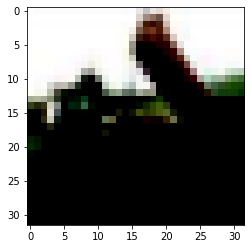

In [9]:
plt.imshow(np.transpose(train_X_baseline[2], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


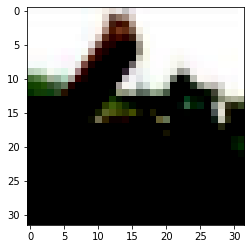

In [10]:
plt.imshow(np.transpose(augmented_X[90002], (1,2,0)))

## Model Creation

In [11]:
class Convnet(nn.Module):
    def __init__(self):
        super(Convnet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10,  kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.layer3 = torch.nn.Linear(5*5*10, 20)
        torch.nn.init.kaiming_normal_(self.layer3.weight)
        self.layer4=torch.nn.Linear(20, 10)
        torch.nn.init.kaiming_normal_(self.layer4.weight)
        self.act=nn.ReLU()

    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.pool1(out1)
        out3 = self.act(self.conv2(out2))
        out4 = self.pool2(out3)
        out5 = out4.reshape(out4.size(0), out4.size(1)*out4.size(2)*out4.size(3))
        out6 = self.act(self.layer3(out5))
        out7 = self.layer4(out6)
        return out7

## Function for Accuracy Calculation

In [12]:
def accuracy(model,test_X,test_Y):

  with torch.no_grad():
      correct = 0
      total = 0
    
      labels = test_Y.cuda()
      outputs = model(test_X).cuda()
      # print(outputs,"outputs")
      # print(torch.max(outputs.data, 1),"max")
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      print(labels.size(0),"labels size")
      # print(predicted,"predicted")

      # print(labels,"labels")

      correct += (predicted == labels).sum().item()
      accuracy =100 * correct / total
  return accuracy

In [13]:
net = Convnet().cuda()

In [14]:
def function_for_cal(model,input,train,validation_X,validation_Y):
  
  validation_X=torch.FloatTensor(validation_X).cuda()
  validation_Y=torch.tensor(validation_Y).type(torch.LongTensor).cuda()
  input= torch.FloatTensor(input).cuda()
  train=torch.tensor(train).type(torch.LongTensor).cuda()

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
  errt=[0 for i in range(200)]
  validation_accuracy=[]
  test_accuracy=[]
  for epoch in range(200):
      running_loss=0
      for j in range(int(len(input)/300)):
          # Move tensors to the configured device
      
          images= input[j*300:(j+1)*300]
          labels= train[j*300:(j+1)*300]
          
          # Forward pass
          outputs = net(images.cuda()).cuda()
          
          loss = criterion(outputs.cuda(), labels.cuda())
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss+=loss.item()
      
      errt[epoch]=running_loss*(300/len(input))

      valida= accuracy(net,validation_X,validation_Y)
      # testa=accuracy(net,testX_set,testY_set)
      validation_accuracy.append(valida)
      # test_accuracy.append(testa)
      print("Epoch:", epoch,"Loss:",running_loss*(300/len(input)),"validation accuracy:",valida)

  return validation_accuracy

In [15]:
valid_accuracy_baseline= function_for_cal(net,train_X_baseline,train_Y_baseline,valid_X,valid_Y)

5000 labels size
Epoch: 0 Loss: 1.9395380028088889 validation accuracy: 39.92
5000 labels size
Epoch: 1 Loss: 1.5638329188028972 validation accuracy: 46.88
5000 labels size
Epoch: 2 Loss: 1.4356596819559735 validation accuracy: 50.2
5000 labels size
Epoch: 3 Loss: 1.36479558467865 validation accuracy: 52.7
5000 labels size
Epoch: 4 Loss: 1.3144468625386556 validation accuracy: 54.06
5000 labels size
Epoch: 5 Loss: 1.2762292122840881 validation accuracy: 55.44
5000 labels size
Epoch: 6 Loss: 1.2457940141359967 validation accuracy: 56.42
5000 labels size
Epoch: 7 Loss: 1.220348805586497 validation accuracy: 57.62
5000 labels size
Epoch: 8 Loss: 1.198487490018209 validation accuracy: 58.16
5000 labels size
Epoch: 9 Loss: 1.1798916975657145 validation accuracy: 58.54
5000 labels size
Epoch: 10 Loss: 1.1639101751645407 validation accuracy: 59.0
5000 labels size
Epoch: 11 Loss: 1.1499624355634055 validation accuracy: 59.58
5000 labels size
Epoch: 12 Loss: 1.1365288627147676 validation accura

In [16]:
net1=Convnet()
valid_accuracy_augment=function_for_cal(net1,augmented_X,augmented_Y,valid_X,valid_Y)

5000 labels size
Epoch: 0 Loss: 0.8837514728307725 validation accuracy: 65.72
5000 labels size
Epoch: 1 Loss: 0.8761367761095366 validation accuracy: 65.98
5000 labels size
Epoch: 2 Loss: 0.8727721441785495 validation accuracy: 65.92
5000 labels size
Epoch: 3 Loss: 0.8701228965322177 validation accuracy: 66.0
5000 labels size
Epoch: 4 Loss: 0.8677936989068985 validation accuracy: 66.42
5000 labels size
Epoch: 5 Loss: 0.8660689620176951 validation accuracy: 66.72
5000 labels size
Epoch: 6 Loss: 0.8642991911371549 validation accuracy: 66.84
5000 labels size
Epoch: 7 Loss: 0.8624903870622318 validation accuracy: 66.7
5000 labels size
Epoch: 8 Loss: 0.8610283620158832 validation accuracy: 66.76
5000 labels size
Epoch: 9 Loss: 0.8595732838908832 validation accuracy: 66.68
5000 labels size
Epoch: 10 Loss: 0.8580597048004469 validation accuracy: 66.7
5000 labels size
Epoch: 11 Loss: 0.8565224531292915 validation accuracy: 66.66
5000 labels size
Epoch: 12 Loss: 0.8552387315034867 validation ac

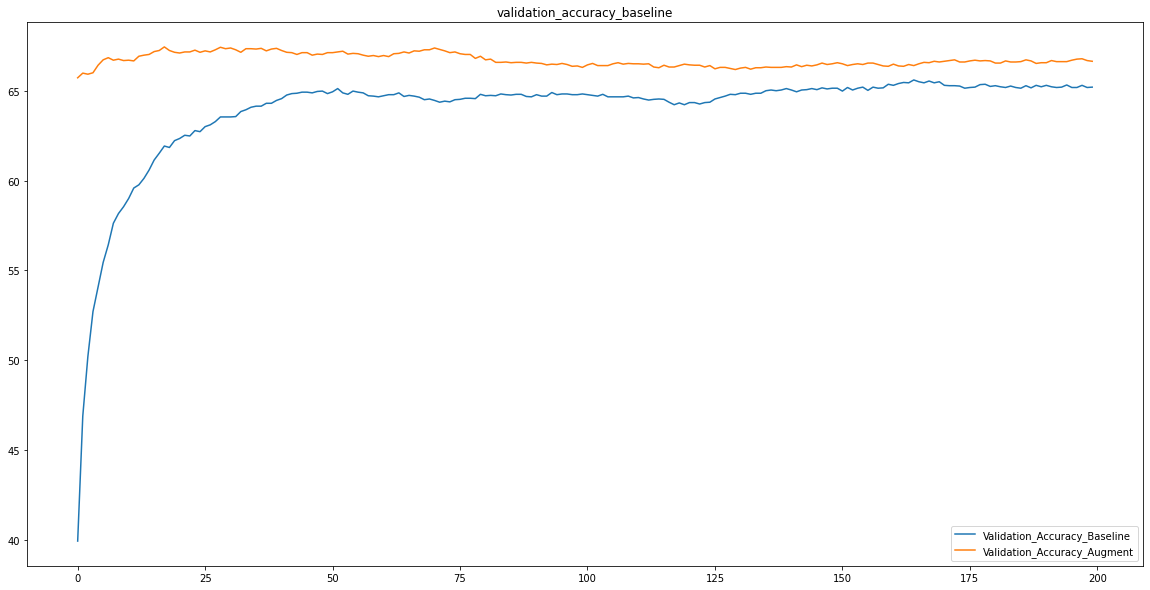

In [17]:
plt.figure(figsize=(20,10))
plt.plot(valid_accuracy_baseline,label="Validation_Accuracy_Baseline")
plt.plot(valid_accuracy_augment,label="Validation_Accuracy_Augment")
plt.legend()
plt.title('validation_accuracy_baseline')
plt.show()